# Swirl correction
The purpose of the project is to identify and correct the portion of the input image affected by a moderate swirl effect.

The center, radius and intensity of the swirl is variable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import swirl, resize
from skimage.draw import disk
from tensorflow.keras import layers, models
import tensorflow as tf
import tensorflow_datasets as tfds

We work on a medium resolution dataset of natural images

In [2]:
def load_flowers_dataset(num_samples=1000, img_size=128):
    ds = tfds.load('tf_flowers', split='train', shuffle_files=True)
    ds = ds.map(lambda x: tf.image.resize(x['image'], (img_size, img_size)) / 255.0)
    ds = ds.take(num_samples).batch(num_samples)
    images = next(iter(ds)).numpy()
    return images

In [3]:
# === CONFIGURATION ===
IMG_SIZE = 128
DEFECT_RADIUS = 32  # max pixel radius of swirl defect
STRENGTH = 4 #max swirl strength

Let us slightly reduce

In [4]:
def preprocess_image(sample):
    """Resize and normalize image"""
    image = tf.image.resize(sample['image'], (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image

The following function generate a different swirl effect for each image.

In [5]:
def generate_swirl_defect(image_np):
    h, w = image_np.shape[:2]
    radius = int(DEFECT_RADIUS * np.random.uniform(0.5, 1.))
    strength = STRENGTH * np.random.uniform(0.5, 1.)
    center = np.random.randint(radius, h - radius, size=2)
    swirled = swirl(image_np, center=center[::-1], strength=strength, radius=radius)
    mask = np.zeros((h, w, 1), dtype=np.uint8)
    rr, cc = disk(center, radius, shape=(h, w))
    mask[rr, cc] = 1
    return swirled.astype(np.float32), mask

Here is a simple generator. Feel free to adapt it to your needs.
*   you cannot pass the mask as input to the network (but you may try to predict it, if you want)
*   you may regenerate the swirl dynamically at each epoch for data augmentation priurposes, if required.



In [7]:
# === DATA GENERATOR ===
class SwirlDefectGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, batch_size=32, shuffle=True, res="all"):
        self.images = images
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(images))
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.res = res

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_clean = self.images[batch_indices]
        batch_defected = []
        batch_masks = []
        for img in batch_clean:
            swirled, mask = generate_swirl_defect(img)
            batch_defected.append(swirled)
            batch_masks.append(mask)
        if self.res == "all":
            return np.array(batch_defected), np.array(batch_masks), np.array(batch_clean)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [8]:
# === LOAD & SPLIT FLOWER DATA ===
def load_flower_dataset_splits(num_train=3000, num_val=300, num_test=370):
    ds = tfds.load('tf_flowers', split='train', shuffle_files=True)
    ds = ds.map(preprocess_image) #.take(num_train + num_val + num_test)
    all_images = tf.stack(list(ds))
    print(len(all_images))
    return (
        all_images[:num_train].numpy(),
        all_images[num_train:num_train + num_val].numpy(),
        all_images[num_train + num_val:num_train + num_val + num_test].numpy()
    )

In [11]:
train_imgs, val_imgs, test_imgs = load_flower_dataset_splits()

train_gen = SwirlDefectGenerator(train_imgs, batch_size=32,res="all")
val_gen = SwirlDefectGenerator(val_imgs, batch_size=32, res="all")
test_gen = SwirlDefectGenerator(test_imgs, batch_size=32,res="all")

3670


(32, 128, 128, 3)


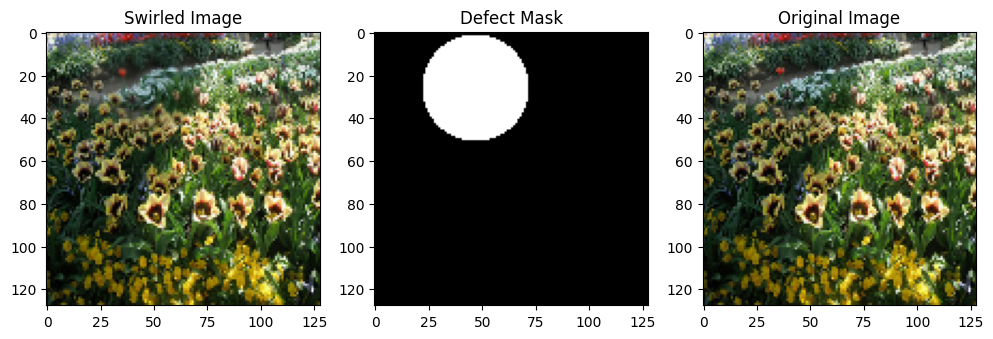

In [13]:
# Sanity check
idx = np.random.randint(0, len(test_gen) - 1)
x_batch, y_mask, y_clean = test_gen[idx]
print(y_clean.shape)
y_clean = y_clean[:,:,:,0:3]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_batch[0])
plt.title("Swirled Image")

plt.subplot(1, 3, 2)
plt.imshow(y_mask[0].squeeze(), cmap='gray')
plt.title("Defect Mask")

plt.subplot(1, 3, 3)
plt.imshow(y_clean[0])
plt.title("Original Image")
plt.show()


As you may see from the examples, the swirl is not always easily identifiable by a human. The network can locate it quite easily (you may try if you like); the actual challenge consists in correcting the effect.

A pipilene of multiple networks may be acceptable. You should not rely on the knowledge that the defect was due to a swirl.

# Evaluation metric

The generated image should be evaluated ONLY on the region corresponding to the mask. In addition this will be compared with the initial distance introduced by the swirl operation

Let us compute this "initial" error:

In [19]:
# Select a batch from the test generator
idx = np.random.randint(0, len(test_gen) - 1)
x_batch_defected, x_batch_mask, y_batch_clean = test_gen[idx]
# Compute initial distance between swirled image and original for the batch
initial_mse_imgs = np.mean((x_batch_defected - y_batch_clean)**2*x_batch_mask,axis=(1,2,3))
initial_mse_batch = np.mean(initial_mse_imgs)
print(f"Initial error introduced by swilr: {initial_mse_batch:.4f}")

Initial error introduced by swilr: 0.0008


The initial error quite low. To better emphasize the correction we compute the ratio between the resulting error and the initial one.
**This should be a value between 0 (perfect reconstruction) and 1 (no reconstruction). Higher values mean you are doing things worse.**

In [ ]:
# Predict the repaired images
generated_images = your_model.predict([x_batch_defected, x_batch_mask])

# Compute the distance between generated image and original for the batch
generated_mes_batch = np.mean((generated_images - y_batch_clean_img)**2*x_batch_mask,axis=(1,2,3))
# Now let us compute the ratio, and the average over the batch
mean_ratio = np.mean(generated_mes_batch/initial_mse_batch)

print(f"Average score (Generated / Initial): {mean_ratio:.4f}")

Repeat the previous computation for all batches in testing data, and return mean and standard deviation.

# Parameters

Try to keep below 4M parameters (total, excluding parameteres of the optimizer).

You have the usual constraints:
* the project should be written in keras
* you should submit a single well documented notebook
* try to give access to weights through gdown


